<a href="https://colab.research.google.com/github/Kobajojn/FYRP_U-Net_Architecture/blob/main/U_net_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [176]:
!pip install tacoreader rasterio

Text(0.5, 1.0, 'Human label')

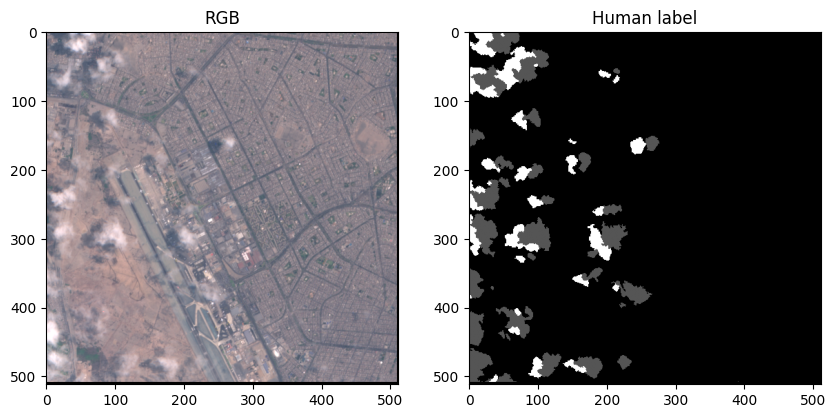

In [177]:
# @Setup and accessing CloudSEN12+
# REWRITE WHOLE SECTION - COPIED

import tacoreader
import rasterio as rio
import matplotlib.pyplot
import numpy
import torch

# initalise and set up the logger

# Select one image from the test dataset
ds = tacoreader.load("tacofoundation:cloudsen12-l1c")
subset = ds[(ds["tortilla:data_split"] == "test") & (ds["label_type"] == "high") & (ds["real_proj_shape"] == 509)] #splits the file into segments - rewrite - from tacoreader library

# Read only one sample
sample_idx = 271
s2_l1c = subset.read(sample_idx).read(0)
s2_label = subset.read(sample_idx).read(1)

# Retrieve the S2 data - EDIT TO BE MORE READABLE
with rio.open(s2_l1c), rio.open(s2_label):
    s2_l1c_data = rio.open(s2_l1c).read(window=rio.windows.Window(0, 0, 512, 512)) / 10_000   # (13, 512, 512) ndarray (numpy)
    s2_label_data = rio.open(s2_label).read(window=rio.windows.Window(0, 0, 512, 512))        #var is a string with links to hugging face

# Graphing image with human determined labels
datapoint_rgb = numpy.moveaxis(s2_l1c_data[[3, 2, 1]], 0, -1) * 3  #REWRITE - ensure that the dimensionality exploited is the colour channels #TODO understand technique
fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(datapoint_rgb)
ax[0].set_title("RGB")
ax[1].imshow(s2_label_data[0], cmap="gray")
ax[1].set_title("Human label")

In [178]:
type(s2_l1c_data)

tensor_datapoint_rgb = torch.from_numpy(datapoint_rgb);
tensor_datapoint_rgb = tensor_datapoint_rgb.to(torch.float32)

In [179]:
import torch
import torch.nn as nn

device = "cpu"

# ENCODER LAYER - going "down the U"; i.e decreasing the resolution at the for more colour channels

class conv_layer(nn.Module):
  """
  Decreases the spatial resolution of the image for more colour/feature channels.
    Used in both encoder and decoder segments.
    Applies a convolution (3x3) and ReLU to the image twice to the image.
    1x convolution reduces the resolution by 2 pixels and 2x the colour channels.

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.
  foward() Args:
    img (tensor float32) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    output (tensor float32) - The output image after transformations.
  """
  def __init__ (self, channels_in): # Parameters go here!
    super().__init__()

    # Convolution 1 - a sliding window function
    self.conv1 = nn.Conv2d(
        in_channels = channels_in,
        out_channels = channels_in * 2,
        kernel_size = 3,
        stride = 1,
        # padding = 1,                    # padded with zeros to ensure dimensions are always even
        # padding_mode = 'zeros',         # [30] recommends an unpadded convolution
        # bias = True # defaults to True - is a learned bias to Output
        dtype = torch.float32
    )
    # Convolution 2 - a sliding window function
    self.conv2 = nn.Conv2d(
        in_channels = channels_in * 2,
        out_channels = channels_in * 2,
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    )
    # Rectified Linear Unit 1 - A non-linear activation function
    self.relu = nn.ReLU()

  def forward(self, img):
    output = self.conv1(img)
    output = self.relu(output)
    output = self.conv2(output)
    output = self.relu(output)
    return output


class encoder_layer(nn.Module):
  """
  Decreases the spatial resolution of the image for more colour/feature channels.
    Main core segment of the encoder stage.
    Applies a convolution (3x3) and ReLU to the image twice then (2x2) pool to the image.

    1x pooling downsamples the resolution by x0.5.

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.
  foward() Args:
    img (tensor float32) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    postpool_output (tensor float32) - The output image after pooling.
    prepool_output (tensor float32) - The output image before pooling. Used in concatenation.
  """
  def __init__ (self): # Parameters go here!
    super().__init__()

    # A 2x2 kernal is used, with a stride/offset of 2 pixels
    self.pooling = nn.MaxPool2d(
        kernel_size = (2, 2),
        stride = 2,
    )

  def forward(self, img, channels_in):
    conv_forward = conv_layer(channels_in = channels_in)
    output = conv_forward(img)

    prepool_output = output
    postpool_output = self.pooling(output) # Final transformation to image

    return postpool_output, prepool_output


In [180]:
def tensor_info(tensor_input, tensor_name):
  """
  Prints off a list of the tensor's details including:  \
    Datatype, Shape, Size, and the device location stored in memory

  foward() Args:
    tensor_input (tensor) - tensor to be examined.
    tensor_name (string) - a string description of the tensor used for descriptive purposes

  return:
    None
  """
  print("Tensor:\t\t\t", tensor_name)
  print("Output Datatype:\t", tensor_input.dtype, "\nOutput Shape:\t\t", tensor_input.shape, \
      "\nOutput Size:\t\t", tensor_input.size(), \
      "\nOutput Device:\t\t", tensor_input.device, \
      "\n---------------------------------------------------")
  return None

""" ---VARIABLE NAMING NOMENCLATURE:---
- Alphabetical images correspond to which layer the image was generated on.
e.g. B_pooled is on layer 2.
- "X_pooled" are images generated with 2x2 pooling applied.
- "X_concat" are images generated before pooling. This are for concatenation later.
"""

s2_l1c_data_tensor = torch.from_numpy(s2_l1c_data)
s2_l1c_data_tensor = s2_l1c_data_tensor.to(torch.float32)
s2_l1c_data_tensor = s2_l1c_data_tensor.to(device)
# Crop image such that after 8 convolutions are 4 poolings, the dimensions are always even
s2_l1c_data_tensor = s2_l1c_data_tensor[:, 0:508, 0:508]
# Try using: https://docs.pytorch.org/vision/main/generated/torchvision.transforms.functional.crop.html

tensor_info(s2_l1c_data_tensor, "s2_l1c_data_tensor - initial image")

# Processing the encoder layers
encoder_layer_1 = encoder_layer().to(device)

# Apply image to forward layer
A_pooled, A_concat = encoder_layer_1(s2_l1c_data_tensor, channels_in = 13)
B_pooled, B_concat = encoder_layer_1(A_pooled, channels_in = 26)
C_pooled, C_concat = encoder_layer_1(B_pooled, channels_in = 52)
D_pooled, D_concat = encoder_layer_1(C_pooled, channels_in = 104)

tensor_info(A_pooled, "encoder_layer_1 - A_pooled")
tensor_info(B_pooled, "encoder_layer_2 - B_pooled")
tensor_info(C_pooled, "encoder_layer_3 - C_pooled")
tensor_info(D_pooled, "encoder_layer_4 - D_pooled") # size [208, 28, 28] - final layer

Tensor:			 s2_l1c_data_tensor - initial image
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([13, 508, 508]) 
Output Size:		 torch.Size([13, 508, 508]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 encoder_layer_1 - A_pooled
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([26, 252, 252]) 
Output Size:		 torch.Size([26, 252, 252]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 encoder_layer_2 - B_pooled
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([52, 124, 124]) 
Output Size:		 torch.Size([52, 124, 124]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 encoder_layer_3 - C_pooled
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([104, 60, 60]) 
Output Size:		 torch.Size([104, 60, 60]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 encoder_layer_4 - D_pooled
Output Datatype:	 torch.floa

The image resolution is  (508, 508)
The number of colour channels are  13


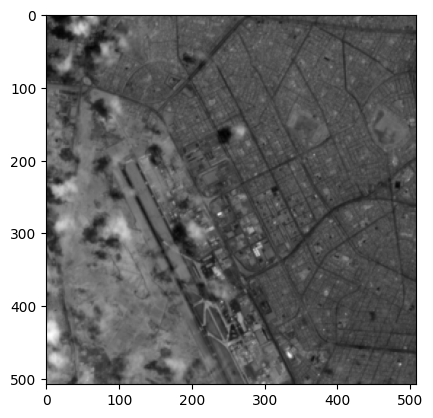

The image resolution is  (124, 124)
The number of colour channels are  52


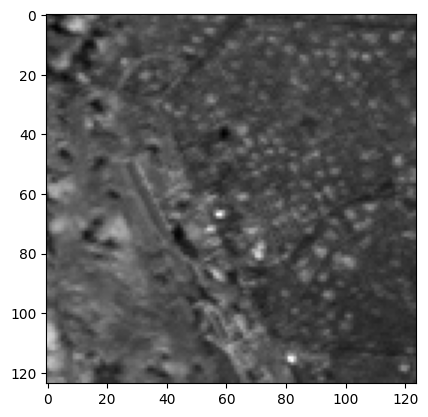

The image resolution is  (60, 60)
The number of colour channels are  104


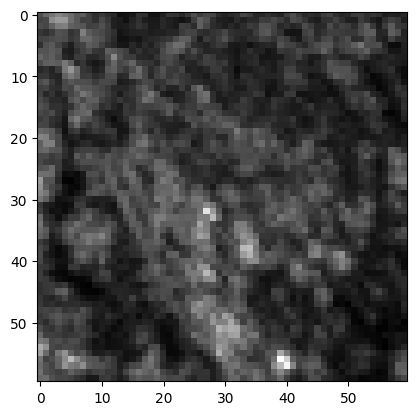

The image resolution is  (28, 28)
The number of colour channels are  208


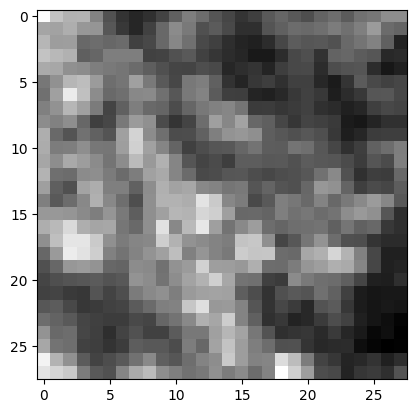

In [206]:
import matplotlib.pyplot
#plt.imshow(B.numpy)

def mash_colour_channel(img):
  """
  Generate a greyscale image of a tensor with more than 3 colour/feature channels. \
    Use primarily for visualisation and debugging purposes of prior transformations.

  foward() Args:
    img (tensor) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    None
  """
  # Temporary - converts from Tensor to numpy - TODO: understand why detach is needed
  img = img.detach().numpy()
  z_size = img.shape[0] # Gathers the size of the z or colour element

  # averages out the colour channel elementwise - main transformation of function
  img_no_colour = numpy.mean(a = img, axis = 0)

  # display image dimension characterisitics and print the image
  print("The image resolution is ", img_no_colour.shape)
  print("The number of colour channels are ", z_size)
  matplotlib.pyplot.gray() # place the image output into greyscale
  matplotlib.pyplot.imshow(img_no_colour)
  matplotlib.pyplot.show()
  return None

# Print off image with the colour channels combined
mash_colour_channel(s2_l1c_data_tensor)
mash_colour_channel(B_pooled)
mash_colour_channel(C_pooled)
mash_colour_channel(D_pooled)

size_difference = 64
The image dimensions are EVEN. Thus padding is applied.
Tensor:			 img_decoder
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([104, 56, 56]) 
Output Size:		 torch.Size([104, 56, 56]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 img_encoder_crop
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([104, 56, 56]) 
Output Size:		 torch.Size([104, 56, 56]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 img_concat (combined colour channels)
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([208, 56, 56]) 
Output Size:		 torch.Size([208, 56, 56]) 
Output Device:		 cpu 
---------------------------------------------------
The image resolution is  (56, 56)
The number of colour channels are  208


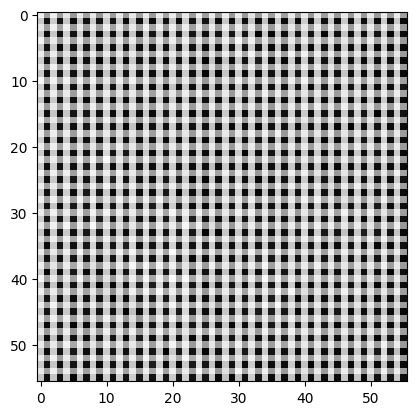

Tensor:			 decoder_layer_1 - C_deconv
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([416, 52, 52]) 
Output Size:		 torch.Size([416, 52, 52]) 
Output Device:		 cpu 
---------------------------------------------------
size_difference = 144
The image dimensions are EVEN. Thus padding is applied.
Tensor:			 img_decoder
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([208, 104, 104]) 
Output Size:		 torch.Size([208, 104, 104]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 img_encoder_crop
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([52, 104, 104]) 
Output Size:		 torch.Size([52, 104, 104]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 img_concat (combined colour channels)
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([260, 104, 104]) 
Output Size:		 torch.Size([260, 104, 104]) 
Output Device:		 cpu 
---------------------------------------------------
The im

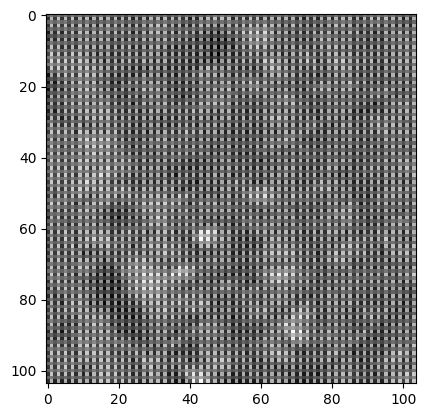

Tensor:			 decoder_layer_2 - B_deconv
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([520, 100, 100]) 
Output Size:		 torch.Size([520, 100, 100]) 
Output Device:		 cpu 
---------------------------------------------------
size_difference = 304
The image dimensions are EVEN. Thus padding is applied.
Tensor:			 img_decoder
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([260, 200, 200]) 
Output Size:		 torch.Size([260, 200, 200]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 img_encoder_crop
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([26, 200, 200]) 
Output Size:		 torch.Size([26, 200, 200]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 img_concat (combined colour channels)
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([286, 200, 200]) 
Output Size:		 torch.Size([286, 200, 200]) 
Output Device:		 cpu 
---------------------------------------------------
Th

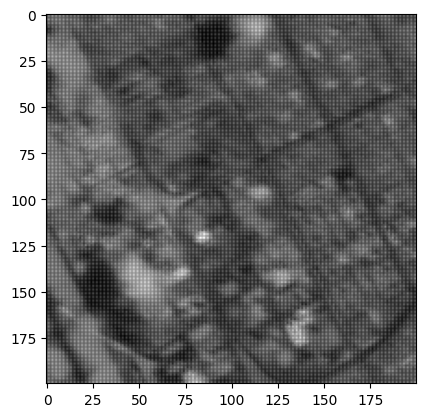

Tensor:			 decoder_layer_3 - A_deconv
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([572, 196, 196]) 
Output Size:		 torch.Size([572, 196, 196]) 
Output Device:		 cpu 
---------------------------------------------------
size_difference = 116
The image dimensions are EVEN. Thus padding is applied.
Tensor:			 img_decoder
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([286, 392, 392]) 
Output Size:		 torch.Size([286, 392, 392]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 img_encoder_crop
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([13, 392, 392]) 
Output Size:		 torch.Size([13, 392, 392]) 
Output Device:		 cpu 
---------------------------------------------------
Tensor:			 img_concat (combined colour channels)
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([299, 392, 392]) 
Output Size:		 torch.Size([299, 392, 392]) 
Output Device:		 cpu 
---------------------------------------------------
Th

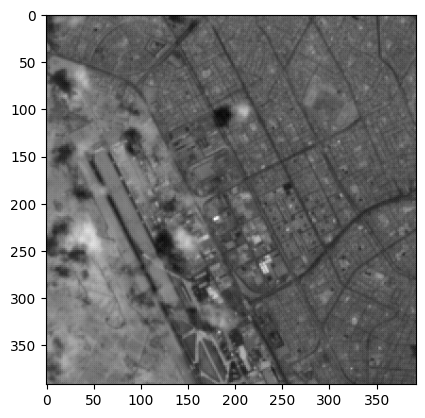

Tensor:			 decoder_layer_4 - Z2
Output Datatype:	 torch.float32 
Output Shape:		 torch.Size([598, 388, 388]) 
Output Size:		 torch.Size([598, 388, 388]) 
Output Device:		 cpu 
---------------------------------------------------


In [205]:
# DECODER LAYER - going "up the U"; i.e increasing the resolution at the expense of less colour channels

class decoder_layer(nn.Module):
  """
  Increases the spatial resolution of the image for less colour/feature channels.
    Apply a (2x2) "deconvolution" transformation to counteract the impacts of pooling and convolution.
    Then a "concatenation_feature()" is applied to double colour channel size.
    The main building block of the decoder side of the U-net model.
    1x deconvolution increases the resolution 2x and the colour channels by x0.5.
    1x "concatenation_features()" to the image (doubles colour channel)

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.

  crop_and_concat() Args:
    img_decoder (tensor float32) - Deconvoluted image from decoder side.
      Image format is [z, x, y] or [w, u, v].
      Only works if [x, y] dimensions are EVEN.
    img_encoder_skip (tensor float32) - Pooled image from encoder side. Larger than img_deconv
      Image format is [z, x, y] or [w, u, v]

  foward() Args:
    img (tensor) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    output (tensor) - The increased spatial resolution image.
  """
  def __init__ (self, channels_in):
    super().__init__()

    self.deconv1 = nn.ConvTranspose2d(
        in_channels = channels_in,
        out_channels = int(channels_in / 2),
        kernel_size = [2, 2], # Deconvolute the image with a 2x2 kernal
        stride = 2,           # to significantly increase the resolution
        dtype = torch.float32
    )

  def crop_and_concat(self, img_decoder, img_encoder_skip):
    """
    Doubles the feature channels of its input image.
      Crops prepool_output from the encoder layer and then concatenates its colour/
      feature channels with the decoder's respective deconvoluted image.

    Args:
      img_decoder (tensor float32) - Deconvoluted image from decoder side.
        Image format is [z, x, y] or [w, u, v].
        Only works if [x, y] dimensions are EVEN.
      img_encoder_skip (tensor float32) - Pooled image from encoder side. Larger than img_deconv
        Image format is [z, x, y] or [w, u, v]

    Returns:
      img_concat (tensor float32) - image with double the inputs colour channels
    """
    # Determining the range of the cropping
    size_difference =  img_encoder_skip.shape[1] - img_decoder.shape[1]
    print(f"{size_difference = }")
    lower_range = int(size_difference / 2)
    upper_range = img_decoder.shape[1] + lower_range

    # Only works if dimensions are even
    if size_difference % 2 == 0:
      print("The image dimensions are EVEN. Thus padding is applied.")

      # Crop the encoded image to fit the resolution of the reduced (in dimensions) decoded image
      img_encoder_crop = img_encoder_skip[:, lower_range:upper_range, lower_range:upper_range]
      tensor_info(img_decoder, "img_decoder")
      tensor_info(img_encoder_crop, "img_encoder_crop")

      # concatenate the colour/feature channels of the encoder and decoder imgs.
      img_concat = torch.cat(tensors = (img_decoder, img_encoder_crop), dim = 0)
      tensor_info(img_concat, "img_concat (combined colour channels)")
      mash_colour_channel(img_concat)

      return img_concat

    else:
      print("The image dimensions are ODD. Thus padding can NOT be applied.", \
        "Please crop the image for a EVEN dimension.")
      return None

  def forward(self, img, img_encoder_skip, channels_in):
    output = self.deconv1(img)
    output = self.crop_and_concat(img_decoder = output, img_encoder_skip = img_encoder_skip)

    # Apply 2x convolutions + 2x ReLU
    conv_layer_1 = conv_layer(channels_in = channels_in)
    output = conv_layer_1(output)
    return output


# Setup
decoder_layer_1 = decoder_layer(channels_in = 208).to(device)
decoder_layer_2 = decoder_layer(channels_in = 416).to(device)
decoder_layer_3 = decoder_layer(channels_in = 520).to(device)
decoder_layer_4 = decoder_layer(channels_in = 572).to(device)

# concatenate prior to merger layer

# TODO: need to make the channels_in less confusing and more straightforward
# the channels are no longer predictable in size - double check
C_deconv = decoder_layer_1(
    img = D_pooled,
    img_encoder_skip = C_concat,
    channels_in = 208
)
tensor_info(C_deconv, "decoder_layer_1 - C_deconv")
B_deconv = decoder_layer_2(
    img = C_deconv,
    img_encoder_skip = B_concat,
    channels_in = 260
)
tensor_info(B_deconv, "decoder_layer_2 - B_deconv")
A_deconv = decoder_layer_3(
    img = B_deconv,
    img_encoder_skip = A_concat,
    channels_in = 286
)
tensor_info(A_deconv, "decoder_layer_3 - A_deconv")
Z2 = decoder_layer_4(
    img = A_deconv,
    img_encoder_skip = s2_l1c_data_tensor,
    channels_in = 299
)
tensor_info(Z2, "decoder_layer_4 - Z2")



# conv_layer_1 = conv_layer(channels_in = 208)
# conv_layer_1(C_deconv)
# A_deconv = conv_layer(channels_in = 52)

# mash_colour_channel(C_deconv)
# mash_colour_channel(B_deconv)
# mash_colour_channel(A_deconv)
# mash_colour_channel(Z_deconv)

In [184]:
#sandpit test for concatenation

# Experimentation and how many channels to add
# tensor_info(D_pooled, "STARTED VALUE - encoder_layer_4 - D1")       # started value
# tensor_info(C_deconv, "CURRENT VALUE - decoder_layer_1 - C_deconv") # current value
# tensor_info(C_pooled, "DESIRED VALUE - encoder_layer_3 - C1")       # desired value

# print("\n")
# tensor_info(C_pooled, "STARTED VALUE - encoder_layer_3 - C1")       # started value
# tensor_info(B_deconv, "CURRENT VALUE - decoder_layer_2 - B_deconv") # current value
# tensor_info(B_pooled, "DESIRED VALUE - encoder_layer_2 - B1")       # desired value
# print("\n")
# # Later cases - use to prove relationship
# tensor_info(B_pooled, "STARTED VALUE - encoder_layer_4 - D1")       # started value
# tensor_info(A_deconv, "CURRENT VALUE - decoder_layer_1 - C_deconv") # current value
# tensor_info(A_pooled, "DESIRED VALUE - encoder_layer_3 - C1")       # desired value
# print("\n")
# tensor_info(A_pooled, "STARTED VALUE - encoder_layer_4 - D1")       # started value
# tensor_info(Z_deconv, "CURRENT VALUE - decoder_layer_1 - C_deconv") # current value
# tensor_info(s2_l1c_data_tensor, "DESIRED VALUE - encoder_layer_3 - C1")       # desired value
# print("\n PROPAGATED VALUES")
# tensor_info(C_deconv, "C_deconv")       # not-propagated value
# tensor_info(B_deconv1, "B_deconv1 propagated")       # propagated value
# tensor_info(A_deconv1, "A_deconv1 propagated")       # propagated value
# tensor_info(Z_deconv1, "Z_deconv1 propagated")       # propagated value


## todo:
1. work out how to transfer images and visualise progress
2. determine required images and what I should use
3. being to save progress
4. make the model tech agnostic
5. Get a logger setup - requires a working file directory
```
import logging
self.logger = logging.getLogger(__name__)
```
## todo big picture:
1. get rough model working
2. build the Unet model

##Useful knowledge:
1. keyboard shortcut to comment and uncomment out things is ctrl + "/"
2. The U-net model requires that the encoder/decoder colour channel follows the following pattern: 1 - 64 - 128 - 256 - 512
3. Refer to "https://stackoverflow.com/questions/57530038/concatenation-step-of-u-net-for-unequal-number-of-channels" for more information
